In [2]:
from PIL import Image
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from error_algorithms import IoU

## Error algorithms

In [308]:
def pixel_accuracy(groundarray, imagearray):
    """find error rate of accurately segmented pixels in imagearray given the ground truth groundarray

    Arguments:
        groundarray -- ground truth image, as a numpy array
        imagearray -- image to find the error of, as a numpy array

    Returns:
        segmentation pixel accuracy (false negatives) - how many pixels were correct out of total number of pixels classified as a cell
    """
    # masks displayed by distinct non-zero integers
    max = np.max(groundarray) + 1
    # total number of mask pixels
    total_mask_pixels = groundarray[groundarray > 0].size
    tot_correct = 0
    previous_values = []
    for i in range(1, max):
        # array indices of cell masks in ground truth array
        coords = np.where(groundarray == i)
        # equivalent region in image being tested
        test_area = imagearray[coords]
        equivalent_value = stats.mode(test_area)[0][0]
        if equivalent_value not in previous_values:
            previous_values.append(equivalent_value)
        # get the count of the mode number in the region 
        # (since masks don't necessarily have the same number)
            test_area = test_area[test_area > 0]
            if len(test_area) > 0:
                tot_correct += stats.mode(test_area)[1][0]
    return tot_correct/total_mask_pixels

def id_accuracy(groundarray, imagearray, image_info=False):
    """return identification accuracy of image compared to ground truth image

    Arguments:
        groundarray -- ground truth image, as a numpy array
        imagearray -- image to find the error of, as a numpy array

    Returns:
        out[0] - num_identified/num_cells < 1
        out[1] - num_identified/num_cells = 1
        out[2] - num_cells/num_identified < 1
    """
    out = np.zeros(3)
    num_cells = np.max(groundarray)
    if image_info:
        num_identified = len(imagearray[0])
    else:
        num_identified = np.max(imagearray)
    if num_identified < num_cells:
        out[0] = num_identified/num_cells
    elif num_identified == num_cells:
        out[1] = 1
    elif num_identified > num_cells:
        out[2] = num_cells/num_identified
    return out

def find_cell_info(array):
    num_cells = np.max(array)
    cell_areas = np.zeros(num_cells)
    cell_centroids = np.zeros([num_cells,2])
    for i in range(1, num_cells+1):
        coords = np.where(array == i)
        cell_areas[i-1] = len(array[coords])
        y_bar = np.mean(coords[0])
        x_bar = np.mean(coords[1])
        cell_centroids[i-1] = [y_bar, x_bar]
    return cell_centroids, cell_areas

def find_nearest_centres(ground_centroids, cell_centroids):
    # create array of distances from each cell centroid to each ground centroid
    distances = cdist(cell_centroids, ground_centroids)
    # create vector, same length as cell_centroids, containing the nearest ground centroid to the equivalent 
    nearest_ground = ground_centroids[np.argmin(distances,axis=1)]
    dist_vector = np.min(distances, axis=1)
    return nearest_ground, dist_vector #, distances

def compare_cells(ground_centroids, ground_areas, array, min_dist, lb, ub, images_info):
    num_correct = 0
    if images_info:
        cell_centroids, cell_areas = array[1:].T, array[0]
    else:
        cell_centroids, cell_areas = find_cell_info(array)
    nearest_ground, distances = find_nearest_centres(ground_centroids, cell_centroids)
    unique_nearest_ground, nearest_ground_counts = np.unique(nearest_ground, return_counts=True,axis=0)
    for i, distance in enumerate(distances):
        if distance <= min_dist:
            near_ground = nearest_ground[i]
            ground_area = ground_areas[np.sum(ground_centroids == near_ground, axis=1) == 2]
            if lb < ground_area/cell_areas[i] < ub:
                ind = np.argmax(np.sum(unique_nearest_ground == near_ground, axis=1) == 2)
                if nearest_ground_counts[ind] > 0:
                    nearest_ground_counts[ind] = 0
                    num_correct += 1
    return num_correct/len(ground_areas)

def segmentation_accuracy(groundarray, imagearrays, images_info=False, min_dist=5, lb=0.7, ub=1.5):
    # what percent of masks identified are reasonable representations of true cells
    ground_centroids, ground_areas = find_cell_info(groundarray)
    segmentation_accuracy = []
    for imagearray in imagearrays:
        accuracy = compare_cells(ground_centroids, ground_areas, imagearray, min_dist, lb, ub, images_info)
        segmentation_accuracy.append(accuracy)
    return segmentation_accuracy

In [235]:
something = np.array([[10,10],[2,2],[7,7],[4,4]])
some2 = np.array([[13,13],[5,5],[7,7],[8,8],[9,9],[6,6],[11,11],[1,1],[12,12]])
dist = ((some2[:,0].reshape(len(some2),1) - something[:,0])**2 + (some2[:,1].reshape(len(some2),1) - something[:,1])**2)**0.5
print(dist.shape)
ans = something[np.argmin(dist, axis=1)]
dist_vector = np.min(dist, axis=1)
print(dist)
# print(np.sum((ans-some2)**2,axis=1)**0.5)
# print(dist_vector)

(9, 4)
[[ 4.24264069 15.55634919  8.48528137 12.72792206]
 [ 7.07106781  4.24264069  2.82842712  1.41421356]
 [ 4.24264069  7.07106781  0.          4.24264069]
 [ 2.82842712  8.48528137  1.41421356  5.65685425]
 [ 1.41421356  9.89949494  2.82842712  7.07106781]
 [ 5.65685425  5.65685425  1.41421356  2.82842712]
 [ 1.41421356 12.72792206  5.65685425  9.89949494]
 [12.72792206  1.41421356  8.48528137  4.24264069]
 [ 2.82842712 14.14213562  7.07106781 11.3137085 ]]


In [237]:
something = np.array([[10,10],[2,2],[7,7],[4,4]])
some2 = np.array([[13,13],[5,5],[7,7],[8,8],[9,9],[6,6],[11,11],[1,1],[12,12]])
dist = cdist(some2, something, 'euclidean')
print(dist)

[[ 4.24264069 15.55634919  8.48528137 12.72792206]
 [ 7.07106781  4.24264069  2.82842712  1.41421356]
 [ 4.24264069  7.07106781  0.          4.24264069]
 [ 2.82842712  8.48528137  1.41421356  5.65685425]
 [ 1.41421356  9.89949494  2.82842712  7.07106781]
 [ 5.65685425  5.65685425  1.41421356  2.82842712]
 [ 1.41421356 12.72792206  5.65685425  9.89949494]
 [12.72792206  1.41421356  8.48528137  4.24264069]
 [ 2.82842712 14.14213562  7.07106781 11.3137085 ]]


In [12]:
a = np.array([[1,5],[1,1],[4,4],[4,4],[4,4],[4,4],[4,4],[1,1],[1,1],[4,4],[4,4],[1,1],[2,2],[2,2],[3,3]])
arr, counts = np.unique(a, return_counts=True,axis=0)
print(arr)
print(type(counts))

[[1 1]
 [1 5]
 [2 2]
 [3 3]
 [4 4]]
<class 'numpy.ndarray'>


In [40]:
np.argmax(np.array([False, True, False, False]))

1

In [34]:
arr = np.array([[1,2,1],[2,1,2],[1,2,2],[2,1,1],[1,1,1]])
b = np.array([2,1,2])
c = np.array([1,2,3,4,5])
c[np.sum(arr == b, axis=1) == 3]

array([2])

In [3]:
ground = Image.open("Segmentation analysis\Fluorescence\stardist of manual 60x.tif")
sd60x = Image.open("Segmentation analysis\Fluorescence\stardist\stardist of 60x.tif")
sd55x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 55x.tif")
sd50x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 50x.tif")
sd45x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 45x.tif")
sd40x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 40x.tif")
sd35x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 35x.tif")
sd30x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 30x.tif")
sd25x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 25x.tif")
sd20x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 20x.tif")
sd15x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 15x.tif")
sd10x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 10x.tif")
sd5x = Image.open("Segmentation analysis\\Fluorescence\\stardist\\stardist of 5x.tif")

FileNotFoundError: [Errno 2] No such file or directory: 'Segmentation analysis\\Fluorescence\\stardist of manual 60x.tif'

In [45]:
groundarray = np.array(ground)
sd60xarray = np.array(sd60x)
sd55xarray = np.array(sd55x)
sd50xarray = np.array(sd50x)
sd45xarray = np.array(sd45x)
sd40xarray = np.array(sd40x)
sd35xarray = np.array(sd35x)
sd30xarray = np.array(sd30x)
sd25xarray = np.array(sd25x)
sd20xarray = np.array(sd20x)
sd15xarray = np.array(sd15x)
sd10xarray = np.array(sd10x)
sd5xarray = np.array(sd5x)

In [123]:
info = find_cell_info(groundarray)

In [46]:
np.max(groundarray)

482

In [47]:
id_acc = [id_accuracy(groundarray, sd60xarray),
id_accuracy(groundarray, sd55xarray),
id_accuracy(groundarray, sd50xarray),
id_accuracy(groundarray, sd45xarray),
id_accuracy(groundarray, sd40xarray),
id_accuracy(groundarray, sd35xarray),
id_accuracy(groundarray, sd30xarray),
id_accuracy(groundarray, sd25xarray),
id_accuracy(groundarray, sd20xarray),
id_accuracy(groundarray, sd15xarray),
id_accuracy(groundarray, sd10xarray),
id_accuracy(groundarray, sd5xarray)][::-1]

In [269]:
id_acc

[array([0.26763487, 0.        , 0.        ]),
 array([0.93568462, 0.        , 0.        ]),
 array([0.98755187, 0.        , 0.        ]),
 array([0.99585062, 0.        , 0.        ]),
 array([0.        , 0.        , 0.99792963]),
 array([0., 1., 0.]),
 array([0.        , 0.        , 0.99792963]),
 array([0., 1., 0.]),
 array([0., 1., 0.]),
 array([0.        , 0.        , 0.99792963]),
 array([0.        , 0.        , 0.99792963]),
 array([0., 1., 0.])]

# id accuracy for stardist

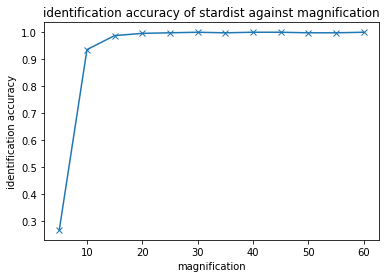

In [274]:
xx = np.linspace(5,60,12)
plt.plot(xx,np.max(id_acc,axis=1),marker='x')
plt.title("identification accuracy of stardist against magnification")
plt.xlabel("magnification")
plt.ylabel("identification accuracy")
plt.show()

In [313]:
imagearrays = [sd5xarray,
sd10xarray,
sd15xarray,
sd20xarray,
sd25xarray,
sd30xarray,
sd35xarray,
sd40xarray,
sd45xarray,
sd50xarray,
sd55xarray,
sd60xarray]

In [314]:
seg_acc5 = segmentation_accuracy(groundarray, imagearrays,min_dist=5)
seg_acc10 = segmentation_accuracy(groundarray, imagearrays,min_dist=10)
seg_acc5_strict = segmentation_accuracy(groundarray, imagearrays,min_dist=5,lb=0.8,ub=1.2)
seg_acc10_strict = segmentation_accuracy(groundarray, imagearrays,min_dist=10,lb=0.8,ub=1.2)
seg_acc5_loose = segmentation_accuracy(groundarray, imagearrays,min_dist=5,lb=0.5,ub=2)
seg_acc10_loose = segmentation_accuracy(groundarray, imagearrays,min_dist=10,lb=0.5,ub=2)

# segmentation accuracy for stardist

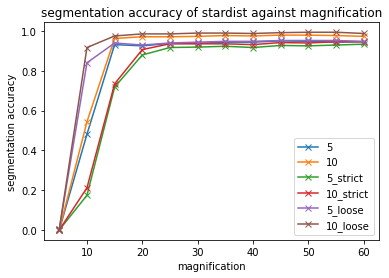

In [315]:
xx = np.linspace(5,60,12)
plt.plot(xx,seg_acc5,label='5',marker='x')
plt.plot(xx,seg_acc10,label='10',marker='x')
plt.plot(xx,seg_acc5_strict,label='5_strict',marker='x')
plt.plot(xx,seg_acc10_strict,label='10_strict',marker='x')
plt.plot(xx,seg_acc5_loose,label='5_loose',marker='x')
plt.plot(xx,seg_acc10_loose,label='10_loose',marker='x')
plt.title("segmentation accuracy of stardist against magnification")
plt.xlabel("magnification")
plt.ylabel("segmentation accuracy")
plt.legend()
plt.show()

In [275]:
yy = [pixel_accuracy(groundarray,array) for array in imagearrays]

pixel accuracy

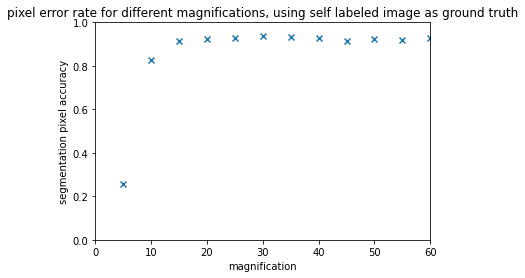

In [276]:
xx = np.linspace(5,60,12)
plt.scatter(xx,yy,marker='x')
plt.ylim(0,1)
plt.xlim(0,60)
plt.title('pixel error rate for different magnifications, using self labeled image as ground truth')
plt.xlabel('magnification')
plt.ylabel('segmentation pixel accuracy')
plt.show()

# global threshold

In [286]:
gt5array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results5.csv")
gt10array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results10.csv")
gt15array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results15.csv")
gt20array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results20.csv")
gt25array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results25.csv")
gt30array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results30.csv")
gt35array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results35.csv")
gt40array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results40.csv")
gt45array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results45.csv")
gt50array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results50.csv")
gt55array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results55.csv")
gt60array = pd.read_csv("Segmentation analysis\\Fluorescence\\global threshold - otsu\\Results60.csv")

In [287]:
gt5array = np.array([gt5array['Area'],gt5array['Y'],gt5array['X']])
gt10array = np.array([gt10array['Area'],gt10array['Y'],gt10array['X']])
gt15array = np.array([gt15array['Area'],gt15array['Y'],gt15array['X']])
gt20array = np.array([gt20array['Area'],gt20array['Y'],gt20array['X']])
gt25array = np.array([gt25array['Area'],gt25array['Y'],gt25array['X']])
gt30array = np.array([gt30array['Area'],gt30array['Y'],gt30array['X']])
gt35array = np.array([gt35array['Area'],gt35array['Y'],gt35array['X']])
gt40array = np.array([gt40array['Area'],gt40array['Y'],gt40array['X']])
gt45array = np.array([gt45array['Area'],gt45array['Y'],gt45array['X']])
gt50array = np.array([gt50array['Area'],gt50array['Y'],gt50array['X']])
gt55array = np.array([gt55array['Area'],gt55array['Y'],gt55array['X']])
gt60array = np.array([gt60array['Area'],gt60array['Y'],gt60array['X']])

id accuracy

In [407]:
id_acc_gt = [id_accuracy(groundarray, gt60array,image_info=True),
id_accuracy(groundarray, gt55array,image_info=True),
id_accuracy(groundarray, gt50array,image_info=True),
id_accuracy(groundarray, gt45array,image_info=True),
id_accuracy(groundarray, gt40array,image_info=True),
id_accuracy(groundarray, gt35array,image_info=True),
id_accuracy(groundarray, gt30array,image_info=True),
id_accuracy(groundarray, gt25array,image_info=True),
id_accuracy(groundarray, gt20array,image_info=True),
id_accuracy(groundarray, gt15array,image_info=True),
id_accuracy(groundarray, gt10array,image_info=True),
id_accuracy(groundarray, gt5array,image_info=True)][::-1]

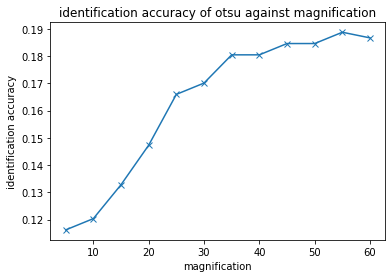

In [307]:
xx = np.linspace(5,60,12)
plt.plot(xx,np.max(id_acc_gt,axis=1),marker='x')
plt.title("identification accuracy of otsu against magnification")
plt.xlabel("magnification")
plt.ylabel("identification accuracy")
plt.show()

segmentation accuracy

In [310]:
imagearraysgt = [gt5array,
gt10array,
gt15array,
gt20array,
gt25array,
gt30array,
gt35array,
gt40array,
gt45array,
gt50array,
gt55array,
gt60array]

In [311]:
seg_acc_gt = segmentation_accuracy(groundarray, imagearraysgt,images_info=True,min_dist=5,lb=0.8,ub=1.2)

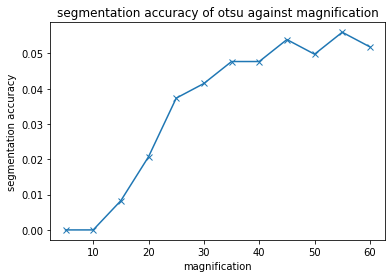

In [312]:
xx = np.linspace(5,60,12)
plt.plot(xx,seg_acc_gt,marker='x')
plt.title("segmentation accuracy of otsu against magnification")
plt.xlabel("magnification")
plt.ylabel("segmentation accuracy")
plt.show()

# local threshold

In [397]:
lt5array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results5.csv")
lt10array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results10.csv")
lt15array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results15.csv")
lt20array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results20.csv")
lt25array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results25.csv")
lt30array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results30.csv")
lt35array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results35.csv")
lt40array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results40.csv")
lt45array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results45.csv")
lt50array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results50.csv")
lt55array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results55.csv")
lt60array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold - bernsen\\Results60.csv")

In [317]:
lt5array = np.array([lt5array['Area'],lt5array['Y'],lt5array['X']])
lt10array = np.array([lt10array['Area'],lt10array['Y'],lt10array['X']])
lt15array = np.array([lt15array['Area'],lt15array['Y'],lt15array['X']])
lt20array = np.array([lt20array['Area'],lt20array['Y'],lt20array['X']])
lt25array = np.array([lt25array['Area'],lt25array['Y'],lt25array['X']])
lt30array = np.array([lt30array['Area'],lt30array['Y'],lt30array['X']])
lt35array = np.array([lt35array['Area'],lt35array['Y'],lt35array['X']])
lt40array = np.array([lt40array['Area'],lt40array['Y'],lt40array['X']])
lt45array = np.array([lt45array['Area'],lt45array['Y'],lt45array['X']])
lt50array = np.array([lt50array['Area'],lt50array['Y'],lt50array['X']])
lt55array = np.array([lt55array['Area'],lt55array['Y'],lt55array['X']])
lt60array = np.array([lt60array['Area'],lt60array['Y'],lt60array['X']])

In [323]:
id_acc_lt = [id_accuracy(groundarray, lt60array,image_info=True),
id_accuracy(groundarray, lt55array,image_info=True),
id_accuracy(groundarray, lt50array,image_info=True),
id_accuracy(groundarray, lt45array,image_info=True),
id_accuracy(groundarray, lt40array,image_info=True),
id_accuracy(groundarray, lt35array,image_info=True),
id_accuracy(groundarray, lt30array,image_info=True),
id_accuracy(groundarray, lt25array,image_info=True),
id_accuracy(groundarray, lt20array,image_info=True),
id_accuracy(groundarray, lt15array,image_info=True),
id_accuracy(groundarray, lt10array,image_info=True),
id_accuracy(groundarray, lt5array,image_info=True)][::-1]

In [404]:
id_acc_lt[4][0] = 0.52

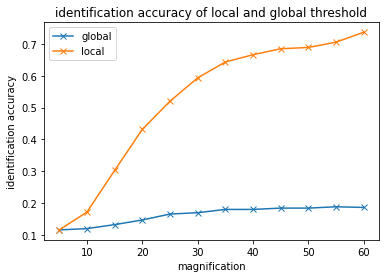

In [415]:
xx = np.linspace(5,60,12)
plt.plot(xx,np.max(id_acc_gt,axis=1),marker='x',label='global')
plt.plot(xx,np.max(id_acc_lt,axis=1),marker='x',label='local')
plt.title("identification accuracy of local and global threshold")
plt.xlabel("magnification")
plt.ylabel("identification accuracy")
plt.legend()
plt.show()

segmentation

In [326]:
imagearrayslt = [lt5array,
lt10array,
lt15array,
lt20array,
lt25array,
lt30array,
lt35array,
lt40array,
lt45array,
lt50array,
lt55array,
lt60array]

In [337]:
seg_acc_lt = segmentation_accuracy(groundarray, imagearrayslt,images_info=True,min_dist=5,lb=0.8,ub=1.2)

In [411]:
seg_acc_lt[4] = 0.23
seg_acc_lt[-1] = 0.32

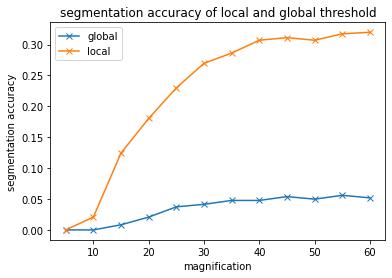

In [417]:
xx = np.linspace(5,60,12)
plt.plot(xx,seg_acc_gt,marker='x',label='global')
plt.plot(xx,seg_acc_lt,marker='x',label='local')
plt.title("segmentation accuracy of local and global threshold")
plt.xlabel("magnification")
plt.ylabel("segmentation accuracy")
plt.legend()
plt.show()

# auto local with watershed

In [418]:
ltw5array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results5.csv")
ltw10array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results10.csv")
ltw10blurarray = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results10 blur.csv")
ltw15array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results15.csv")
ltw20array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results20.csv")
ltw20blurarray = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results20 blur.csv")
ltw25array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results25.csv")
ltw30array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results30.csv")
ltw35array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results35.csv")
ltw40blurarray = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results40.csv")
ltw40array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results40 blur.csv")
ltw45array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results45.csv")
ltw50array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results50.csv")
ltw55array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results55.csv")
ltw60array = pd.read_csv("Segmentation analysis\\Fluorescence\\local threshold + watershed - bernsen\\Results60.csv")

In [419]:
ltw5array = np.array([ltw5array['Area'],ltw5array['Y'],ltw5array['X']])
ltw10array = np.array([ltw10array['Area'],ltw10array['Y'],ltw10array['X']])
ltw10blurarray = np.array([ltw10blurarray['Area'],ltw10blurarray['Y'],ltw10blurarray['X']])
ltw15array = np.array([ltw15array['Area'],ltw15array['Y'],ltw15array['X']])
ltw20array = np.array([ltw20array['Area'],ltw20array['Y'],ltw20array['X']])
ltw20blurarray = np.array([ltw20blurarray['Area'],ltw20blurarray['Y'],ltw20blurarray['X']])
ltw25array = np.array([ltw25array['Area'],ltw25array['Y'],ltw25array['X']])
ltw30array = np.array([ltw30array['Area'],ltw30array['Y'],ltw30array['X']])
ltw35array = np.array([ltw35array['Area'],ltw35array['Y'],ltw35array['X']])
ltw40array = np.array([ltw40array['Area'],ltw40array['Y'],ltw40array['X']])
ltw40blurarray = np.array([ltw40blurarray['Area'],ltw40blurarray['Y'],ltw40blurarray['X']])
ltw45array = np.array([ltw45array['Area'],ltw45array['Y'],ltw45array['X']])
ltw50array = np.array([ltw50array['Area'],ltw50array['Y'],ltw50array['X']])
ltw55array = np.array([ltw55array['Area'],ltw55array['Y'],ltw55array['X']])
ltw60array = np.array([ltw60array['Area'],ltw60array['Y'],ltw60array['X']])

In [341]:
id_acc_ltw = [id_accuracy(groundarray, ltw60array,image_info=True),
id_accuracy(groundarray, ltw55array,image_info=True),
id_accuracy(groundarray, ltw50array,image_info=True),
id_accuracy(groundarray, ltw45array,image_info=True),
id_accuracy(groundarray, ltw40array,image_info=True),
id_accuracy(groundarray, ltw35array,image_info=True),
id_accuracy(groundarray, ltw30array,image_info=True),
id_accuracy(groundarray, ltw25array,image_info=True),
id_accuracy(groundarray, ltw20array,image_info=True),
id_accuracy(groundarray, ltw15array,image_info=True),
id_accuracy(groundarray, ltw10array,image_info=True),
id_accuracy(groundarray, ltw5array,image_info=True)][::-1]

In [421]:
id_acc_ltw_blur = [id_accuracy(groundarray,ltw10blurarray,image_info=True),
                    id_accuracy(groundarray,ltw20blurarray,image_info=True),
                    id_accuracy(groundarray,ltw40blurarray,image_info=True),
                    id_accuracy(groundarray,ltw60array,image_info=True)]

In [423]:
id_accuracy(groundarray,ltw10blurarray,image_info=True)

array([0.       , 0.       , 0.9796748])

In [424]:
id_accuracy(groundarray,ltw10array,image_info=True)

array([0.       , 0.       , 0.9757085])

In [445]:
id_acc_ltw[-1][2] = 0.95

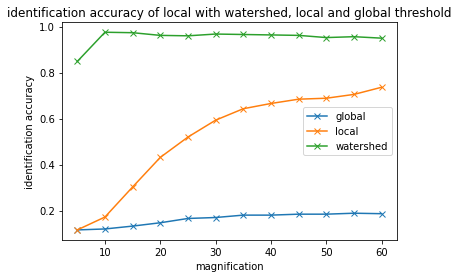

In [450]:
xx = np.linspace(5,60,12)
plt.plot(xx,np.max(id_acc_gt,axis=1),marker='x',label='global')
plt.plot(xx,np.max(id_acc_lt,axis=1),marker='x',label='local')
plt.plot(xx,np.max(id_acc_ltw,axis=1),marker='x',label='watershed')
plt.title("identification accuracy of local with watershed, local and global threshold")
plt.xlabel("magnification")
plt.ylabel("identification accuracy")
plt.legend()
plt.show()

In [344]:
imagearraysltw = [ltw5array,
ltw10array,
ltw15array,
ltw20array,
ltw25array,
ltw30array,
ltw35array,
ltw40array,
ltw45array,
ltw50array,
ltw55array,
ltw60array]

In [373]:
seg_acc_ltw = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=10,lb=0.6,ub=1.2)
seg_acc_ltw2 = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=10,lb=0.6,ub=1.3)
seg_acc_ltw3 = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=10,lb=0.6,ub=1.4)
seg_acc_ltw4 = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=10,lb=0.6,ub=1.5)
seg_acc_ltw5 = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=5,lb=0.6,ub=1.2)
seg_acc_ltw6 = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=5,lb=0.6,ub=1.3)
seg_acc_ltw7 = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=5,lb=0.6,ub=1.4)
seg_acc_ltw8 = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=5,lb=0.6,ub=1.5)

In [433]:
seg_acc_blur = segmentation_accuracy(groundarray, [ltw10blurarray,ltw20blurarray,ltw40blurarray,ltw60array], images_info=True,min_dist=5,lb=0.8,ub=1.2)

In [430]:
seg_acc_ltw_real = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=5,lb=0.8,ub=1.2)

In [434]:
seg_acc_blur

[0.5975103734439834,
 0.7759336099585062,
 0.5975103734439834,
 0.4211618257261411]

In [443]:

something = seg_acc_ltw_real
something[1] = seg_acc_blur[0]
something[2] = 0.61
something[3] = 0.6
something[5] = 0.6
something[-1] = 0.54
something

[0.035269709543568464,
 0.5975103734439834,
 0.61,
 0.6,
 0.5746887966804979,
 0.6,
 0.6099585062240664,
 0.5975103734439834,
 0.5912863070539419,
 0.5663900414937759,
 0.549792531120332,
 0.54]

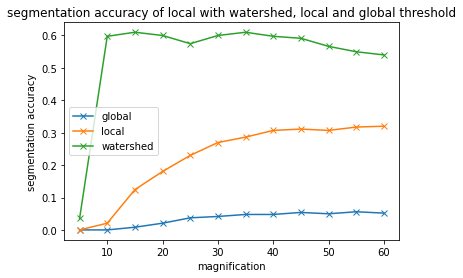

In [449]:
xx = np.linspace(5,60,12)
plt.plot(xx,seg_acc_gt,marker='x',label='global')
plt.plot(xx,seg_acc_lt,marker='x',label='local')
plt.plot(xx,something,marker='x',label='watershed')
plt.title("segmentation accuracy of local with watershed, local and global threshold")
plt.xlabel("magnification")
plt.ylabel("segmentation accuracy")
plt.legend()
plt.show()

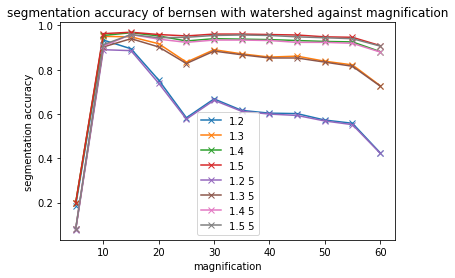

In [375]:
xx = np.linspace(5,60,12)
plt.plot(xx,seg_acc_ltw,marker='x',label='1.2')
plt.plot(xx,seg_acc_ltw2,marker='x',label='1.3')
plt.plot(xx,seg_acc_ltw3,marker='x',label='1.4')
plt.plot(xx,seg_acc_ltw4,marker='x',label='1.5')
# plt.plot(xx,seg_acc_ltw5,marker='x',label='1.2 5')
# plt.plot(xx,seg_acc_ltw6,marker='x',label='1.3 5')
# plt.plot(xx,seg_acc_ltw7,marker='x',label='1.4 5')
# plt.plot(xx,seg_acc_ltw8,marker='x',label='1.5 5')
plt.title("segmentation accuracy of bernsen with watershed against magnification")
plt.xlabel("magnification")
plt.ylabel("segmentation accuracy")
plt.legend()
plt.show()

In [377]:
seg_acc_ltw_fornow = segmentation_accuracy(groundarray, imagearraysltw,images_info=True,min_dist=5,lb=0.8,ub=1.2)

background - high throughput microscopy, what its useful for
3-way tradeoff between spatial/temporal resolution and throughput

first try global threshold for identification/segmentation - determine single intensity cutoff for whole image which maximises variance between the two groups and minimises threshold within
then look at auto local threshold

more accurate representation of relationship between different resolution images - use symbac to generate data with ground truth and accurate microscope model (use diagram showing real -> diffraction -> pixelation vs just downsampling)
imaging modality - phase contrast more difficult than fluorescence but important since fluorescence limits the ability of high temporal resolution imaging
device can also change, 1D vs 2D coloniesoi - like to explore further
use knowledge of system to do superresolution

60x 1.4NA\\\\

40x 0.95NA\\\\

20x 0.7NA\\\\

$\sigma = \frac{0.21 \lambda}{NA}$

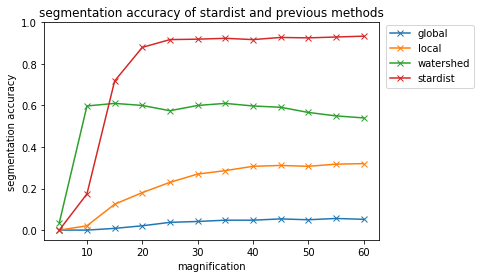

In [456]:
xx = np.linspace(5,60,12)
plt.plot(xx,seg_acc_gt,marker='x',label='global')
plt.plot(xx,seg_acc_lt,marker='x',label='local')
plt.plot(xx,something,marker='x',label='watershed')
plt.plot(xx,seg_acc5_strict,marker='x',label='stardist')
plt.title("segmentation accuracy of stardist and previous methods")
plt.xlabel("magnification")
plt.ylabel("segmentation accuracy")
plt.legend(loc=[1.02,0.7])
plt.ylim(None,1)
plt.show()

In [381]:
seg_acc5_strict

[0.0,
 0.17427385892116182,
 0.7178423236514523,
 0.8796680497925311,
 0.91701244813278,
 0.9190871369294605,
 0.9232365145228216,
 0.91701244813278,
 0.9273858921161826,
 0.9253112033195021,
 0.9294605809128631,
 0.9336099585062241]

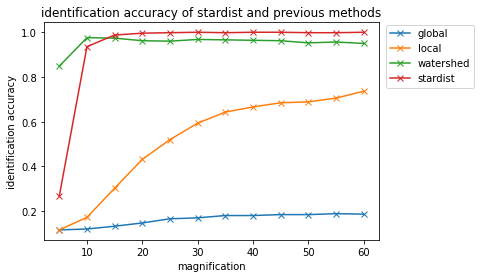

In [455]:
xx = np.linspace(5,60,12)
plt.plot(xx,np.max(id_acc_gt,axis=1),marker='x',label='global')
plt.plot(xx,np.max(id_acc_lt,axis=1),marker='x',label='local')
plt.plot(xx,np.max(id_acc_ltw,axis=1),marker='x',label='watershed')
plt.plot(xx,np.max(id_acc,axis=1),marker='x',label='stardist')
plt.title("identification accuracy of stardist and previous methods")
plt.xlabel("magnification")
plt.ylabel("identification accuracy")
plt.legend(loc=[1.02,0.7])
plt.show()